# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.ar_model import AutoReg
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

%matplotlib inline

# Ignoring Warnings 

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")# Reading Dataset

# Reading Dataset

In [3]:
# Load dataset
df = pd.read_csv(r"C:\Users\vdhus\OneDrive\Desktop\Project Inventory forecast\train.csv")

In [4]:
df['date']=pd.to_datetime(df['date']) # converting date column to datetime64 type.

# Selecting which Store and Item to Forecast

In [5]:
# Take input from the user for store number and item number
store_number = int(input("Enter the store number: "))
item_number = int(input("Enter the item number: "))

# Filter the DataFrame based on user input
df = df[(df['store'] == store_number) & (df['item'] == item_number)].copy()


Enter the store number: 1
Enter the item number: 1


In [6]:
df = df.drop(['store','item'], axis=1)

# Converting dataset from days to month # resampling

In [7]:
df = df.resample('MS', on='date').sum() #resample to train fastly to check whether model is workly good.

# Plot between date and sales

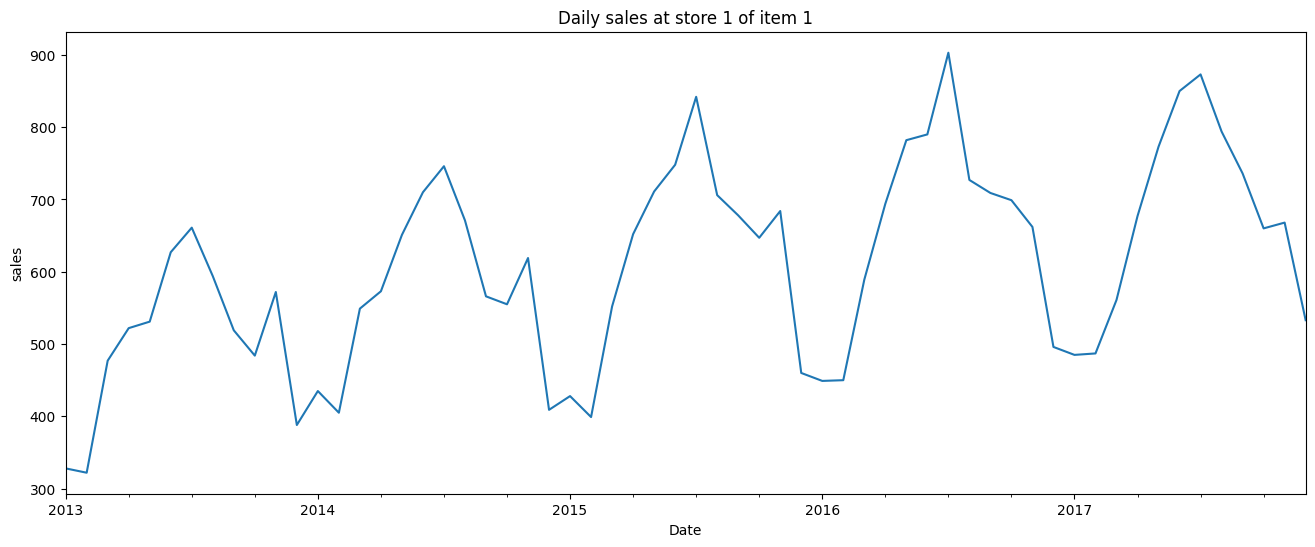

In [8]:
title = 'Daily sales at store 1 of item 1'
ylabel='sales'
xlabel='Date' 

ax = df['sales'].plot(figsize=(16,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# ETS Decomposition to check whether seasonal component contributes or not

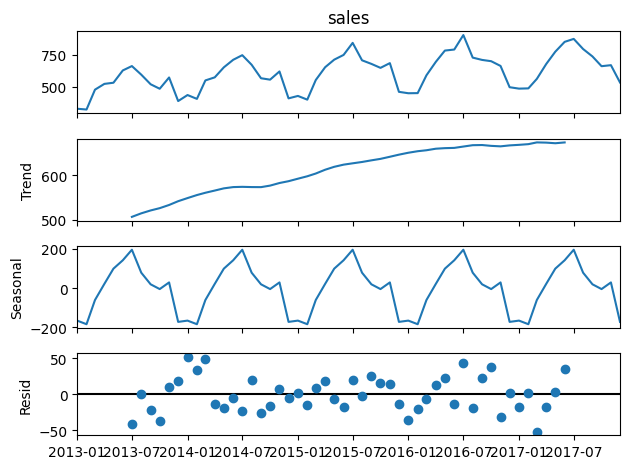

In [9]:
result = seasonal_decompose(df['sales'], model='add')
result.plot();

We can observe that the seasonal component does not contribute significant to the series.

# ACF and PACF plots

In [10]:
# title = 'Autocorrelation: sales'
# plot_acf(df['sales'],title=title,lags=40# Run the ACF and PACF plots# Run the ACF and PACF plots);

In [11]:
# title = 'Partial Autocorrelation: sales'
# plot_pacf(df['sales'],title=title,lags=40);

# Testing the data to check whether its Stationary or NoN-Stationary

In [12]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
adf_test(df['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.148582
p-value                  0.000804
# lags used             11.000000
# observations          48.000000
critical value (1%)     -3.574589
critical value (5%)     -2.923954
critical value (10%)    -2.600039
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Since data is stationary we will now proceed with the training process.

# Choosing the right orders of the ARIMA and SARIMAX models using auto_arima

In [14]:
auto_arima(df['sales'],seasonal=True,m=12).summary()
           
# Choosing the right orders of the ARIMA and SARIMAX models using auto_arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -233.062
Date:                             Sat, 10 Jun 2023   AIC                            470.124
Time:                                     12:08:38   BIC                            473.825
Sample:                                 01-01-2013   HQIC                           471.517
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7018      0.102     -6.858      0.000      -0.902      -0.501
sigma2      1170.3295    294.797      3.970      0.000     592.537    1748.122
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.78   Prob(JB):                         0.49
Heteroskedasticity (H):               1.36   Skew:                             0.38
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Splitting data into Train and Test data

In [15]:
# Set one year for testing
train = df.iloc[:48]
test = df.iloc[48:] # Training ML model and Fitting

# Training ML model, Fitting and Predicting

In [16]:
model = SARIMAX(train['sales'],order=(0,1,1),seasonal_order=(0,1,[],12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -170.576
Date:                             Sat, 10 Jun 2023   AIC                            345.152
Time:                                     12:08:38   BIC                            348.262
Sample:                                 01-01-2013   HQIC                           346.225
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5555      0.160     -3.463      0.001      -0.870      -0.241
sigma2       990.8417    265.051      3.738      0.000     471.351    1510.332
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.68   Prob(JB):                         0.29
Heteroskedasticity (H):               0.91   Skew:                             0.65
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
start=len(train)
end=len(train)+len(test)-1
# Predicting the test data to check whether the model is performing good or bad.
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

In [18]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['sales'][i]}")

predicted=472.8373807, expected=485
predicted=473.8373807, expected=487
predicted=612.8373807, expected=561
predicted=717.8373807, expected=677
predicted=805.8373807, expected=773
predicted=813.8373807, expected=850
predicted=926.8373807, expected=873
predicted=750.8373807, expected=794
predicted=732.8373807, expected=736
predicted=722.8373807, expected=660
predicted=685.8373807, expected=668
predicted=519.8373807, expected=533


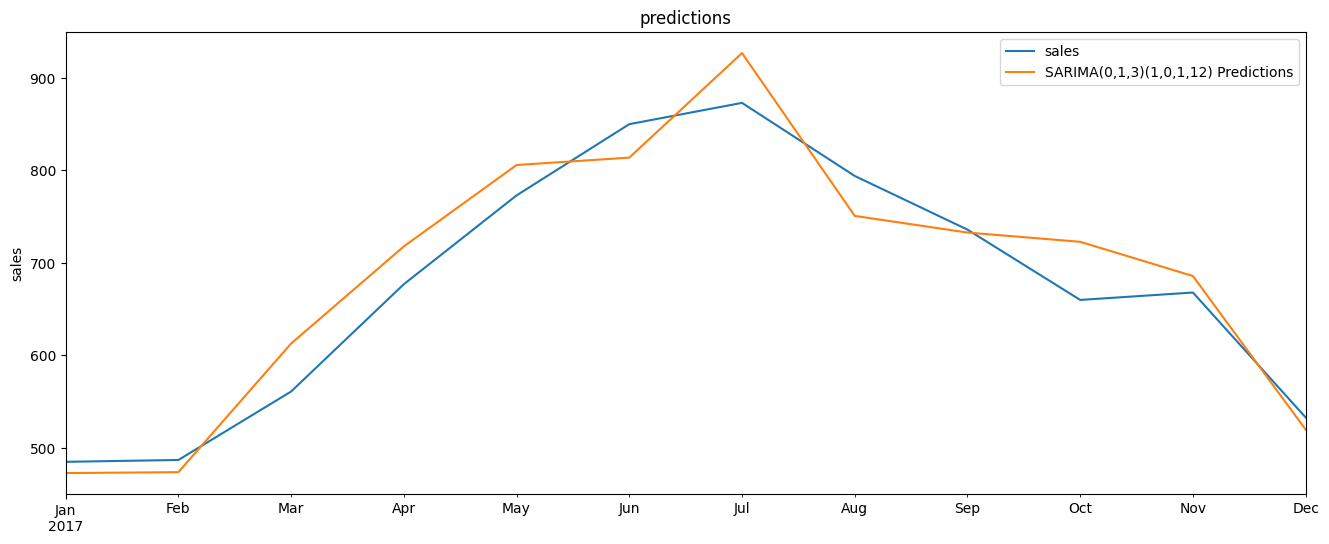

In [19]:
# Plot predictions against known values
title = 'predictions'
ylabel='sales'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(16,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Finding Mean Squared Error and Root Mean Squared Error.

In [20]:
error = mean_squared_error(test['sales'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 1356.121559


In [21]:
error = rmse(test['sales'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 36.82555579


# Asking User start and end dates of the sales prediction

In [22]:

# Get the maximum date from the dataset
max_date = df.index.max()

target_date = max_date - pd.DateOffset(days=1)

start_date = input("Enter start date of sales forecast (YYYY-MM-DD):")
start_date = pd.to_datetime(start_date)

# Ask the user for the target date
user_date_input = input("Enter the target date (YYYY-MM-DD): ")
target_date = pd.to_datetime(user_date_input)

# Calculate the number of months between the maximum date and target date
months = (target_date.year - max_date.year) * 12 + (target_date.month - max_date.month)

# Generate a new range of dates using month frequency
extended_dates = pd.date_range(start=max_date, periods=months+1, freq='MS')

# Extend the dataset with the new dates
df_extended = df.reindex(extended_dates)

# Fill missing values with 0
df_extended.fillna(0, inplace=True)

Enter start date of sales forecast (YYYY-MM-DD):2023-01-01
Enter the target date (YYYY-MM-DD): 2023-12-01


# Predicting the sales upto the end date provided by user.

In [23]:
model = SARIMAX(df['sales'],order=(0,1,1),seasonal_order=(0,1,[],12))
results = model.fit()
forecast = results.predict(len(df),len(df)+len(df_extended),typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

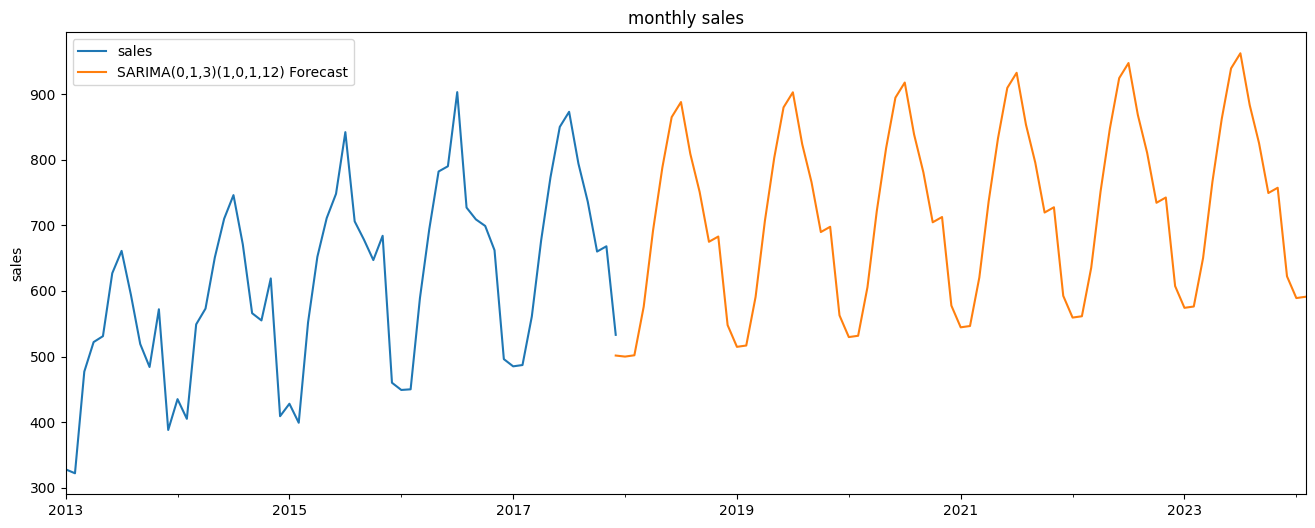

In [24]:
# Plot predictions against known values
title = 'monthly sales'
ylabel='sales'
xlabel=''

ax = df['sales'].plot(legend=True,figsize=(16,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# From forecast data filtering the forecast data of user inputs

In [25]:
date_column = forecast.index


future_df = forecast[(date_column >= start_date) & (date_column <= target_date)].copy()

In [30]:
future_df

2023-01-01    574.212604
2023-02-01    576.212604
2023-03-01    650.212604
2023-04-01    766.212604
2023-05-01    862.212604
2023-06-01    939.212604
2023-07-01    962.212604
2023-08-01    883.212604
2023-09-01    825.212604
2023-10-01    749.212604
2023-11-01    757.212604
2023-12-01    622.212604
Freq: MS, Name: sales prediction, dtype: float64

<AxesSubplot: >

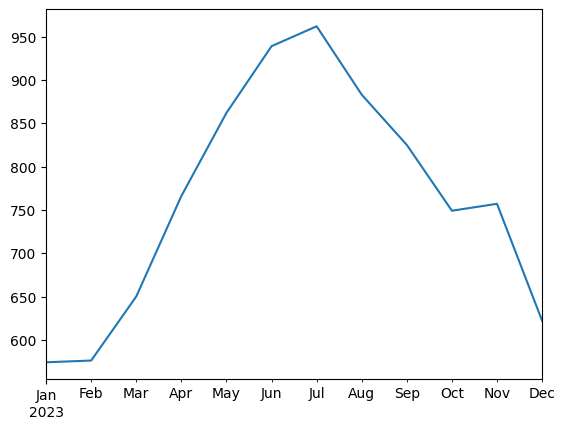

In [26]:
future_df.plot() # plot of predicted sales from start and end dates provided by user

In [27]:
future_df = future_df.rename('sales prediction')

In [28]:
last_column_sum = future_df.sum()
last_column_sum = round(last_column_sum) # calculating the total sum between the user dates and rounding.

In [29]:
print(f"predicted sales at store Number: {store_number} of Item {item_number} from {start_date} to {target_date} is: ", last_column_sum)

predicted sales at store Number: 1 of Item 1 from 2023-01-01 00:00:00 to 2023-12-01 00:00:00 is:  9168
